In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf


convert wav file to spectrogram

In [2]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

Assign to directory

In [3]:
create_pngs_from_wavs(r"A:\Dataset DI\donateacry_corpus\belly_pain", 
                       r"A:\Dataset DI\output\belly_pain")

create_pngs_from_wavs(r"A:\Dataset DI\donateacry_corpus\burping", 
                       r"A:\Dataset DI\output\burping")

create_pngs_from_wavs(r"A:\Dataset DI\donateacry_corpus\discomfort", 
                       r"A:\Dataset DI\output\discomfort")

create_pngs_from_wavs(r"A:\Dataset DI\donateacry_corpus\hungry", 
                       r"A:\Dataset DI\output\hungry")

create_pngs_from_wavs(r"A:\Dataset DI\donateacry_corpus\tired", 
                       r"A:\Dataset DI\output\tired")


load data into folder by label annd processing

In [4]:
x = []
y = []

from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

In [5]:
import os
import glob
import shutil

def move_files(source_pattern, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Directory '{destination_path}' created successfully.")
    else:
        print(f"Directory '{destination_path}' already exists.")

    files_to_move = glob.glob(source_pattern)
    for file_path in files_to_move[:-1]:
        destination_file = os.path.join(destination_path, os.path.basename(file_path))
        if not os.path.exists(destination_file):  # Check if the file already exists
            shutil.move(file_path, destination_path)
            print(f"Moved: {file_path} → {destination_path}")
        else:
            print(f"File already exists: {destination_file}. Skipping.")

# Define your directories and source patterns (Updated for Windows)
directories = {
    r"A:\output\belly_pain_train": r"A:\output\belly_pain\*.png",
    r"A:\output\burping_train": r"A:\output\burping\*.png",
    r"A:\output\discomfort_train": r"A:\output\discomfort\*.png",
    r"A:\output\hungry_train": r"A:\output\hungry\*.png",
    r"A:\output\tired_train": r"A:\output\tired\*.png",
}

# Loop through the directories and move the files
for destination, source_pattern in directories.items():
    move_files(source_pattern, destination)


Directory 'A:\output\belly_pain_train' already exists.
Directory 'A:\output\burping_train' already exists.
Directory 'A:\output\discomfort_train' already exists.
Directory 'A:\output\hungry_train' already exists.
Directory 'A:\output\tired_train' already exists.


In [6]:
import os
from tensorflow.keras.preprocessing import image  # Use this if you're on TensorFlow 2.x

def load_images_from_path(path, label):
    images = []
    labels = []
    for file in os.listdir(path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Filter for image files
            img = image.load_img(os.path.join(path, file), target_size=(224, 224))
            img_array = image.img_to_array(img)  # Should work if imported correctly
            images.append(img_array)
            labels.append(label)
    return images, labels


In [7]:
from tensorflow.keras.utils import to_categorical

# Load images and labels
x, y = [], []  # Initialize x and y
paths = [
    (r"A:\Dataset DI\output\belly_pain", 0),
    (r"A:\Dataset DI\output\burping", 1),
    (r"A:\Dataset DI\output\discomfort", 2),
    (r"A:\Dataset DI\output\hungry", 3),
    (r"A:\Dataset DI\output\tired", 4),
]

for path, label in paths:
    print(f"Loading images from: {path}")
    images, labels = load_images_from_path(path, label)
    x += images
    y += labels

print(f"x shape: {np.array(x).shape}, y shape: {np.array(y).shape}")
print(f"Number of images loaded: {len(x)}, Number of labels loaded: {len(y)}")

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Normalize the image data
x_train_norm = np.array(x_train) / 255.0
x_test_norm = np.array(x_test) / 255.0

# Encode the labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

Loading images from: A:\Dataset DI\output\belly_pain
Loading images from: A:\Dataset DI\output\burping
Loading images from: A:\Dataset DI\output\discomfort
Loading images from: A:\Dataset DI\output\hungry
Loading images from: A:\Dataset DI\output\tired
x shape: (1698, 224, 224, 3), y shape: (1698,)
Number of images loaded: 1698, Number of labels loaded: 1698


In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',padding='same',input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),  # Correct shape
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,077 (49.36 MB)

 Trainable params: 12,939,077 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              min_lr=0.00001,
                              verbose=1)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=20,callbacks=[reduce_lr])

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 363ms/step - accuracy: 0.3075 - loss: 1.8037 - val_accuracy: 0.4382 - val_loss: 1.3710 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - accuracy: 0.5313 - loss: 1.2362 - val_accuracy: 0.7559 - val_loss: 0.7281 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - accuracy: 0.7693 - loss: 0.6650 - val_accuracy: 0.9147 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.9005 - loss: 0.2792 - val_accuracy: 0.9794 - val_loss: 0.1032 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.9650 - loss: 0.1291 - val_accuracy: 0.9824 - val_loss: 0.0611 - learning_rate: 0.0010
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step - accuracy: 0.9640 - loss: 0.1017 - val_accuracy: 0.9794 - val_loss: 0.0544 - learning_rate: 0.0010
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9750 - loss: 0.0

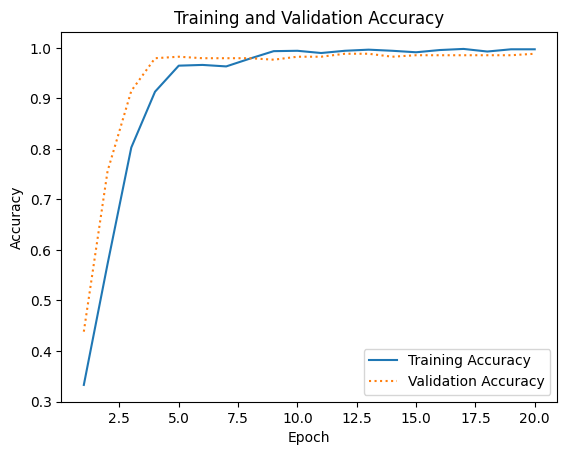

In [10]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

In [ ]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
with open("model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully!")


In [ ]:
prediction = loaded_model.predict(sample_input)


Recording...
Recording complete.
Audio saved as recorded_audio.wav


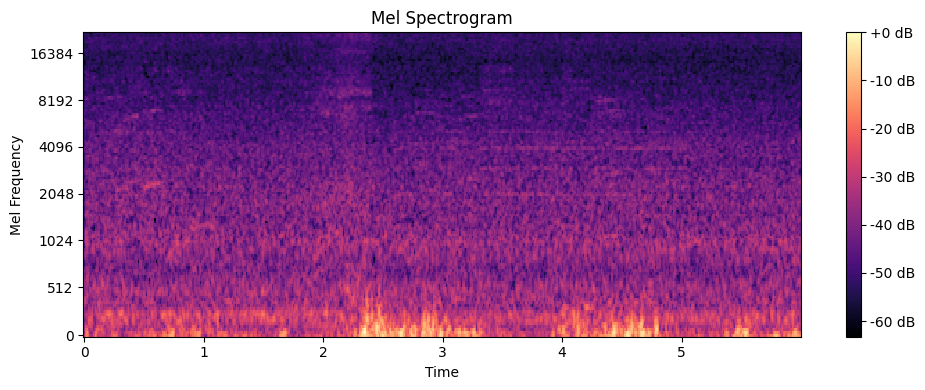

Mel spectrogram saved as mel_spectrogram.png


In [11]:
import sounddevice as sd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import wave

# Recording parameters
DURATION = 6
SAMPLERATE = 44100  # Hz
FILENAME = "recorded_audio.wav"

# Function to record audio
def record_audio():
    print("Recording...")
    audio_data = sd.rec(int(DURATION * SAMPLERATE), samplerate=SAMPLERATE, channels=1, dtype=np.int16)
    sd.wait()  # Wait until recording is finished
    print("Recording complete.")
    
    # Save to a WAV file
    with wave.open(FILENAME, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)  # 16-bit PCM 
        wf.setframerate(SAMPLERATE)
        wf.writeframes(audio_data.tobytes())

    print(f"Audio saved as {FILENAME}")

# Function to convert audio to Mel spectrogram
def audio_to_mel_spectrogram(filename):
    y, sr = librosa.load(filename, sr=None)  # Load the audio file
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB scale

    # Plot and save the Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.savefig("mel_spectrogram.png")
    plt.show()

    print("Mel spectrogram saved as mel_spectrogram.png")

# Run the functions
record_audio()
audio_to_mel_spectrogram(FILENAME)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.99
F1 Score: 0.99
Confusion Matrix:
[[64  0  0  0  0]
 [ 0 21  0  0  0]
 [ 0  0 91  0  0]
 [ 1  1  0 95  2]
 [ 0  0  0  0 65]]


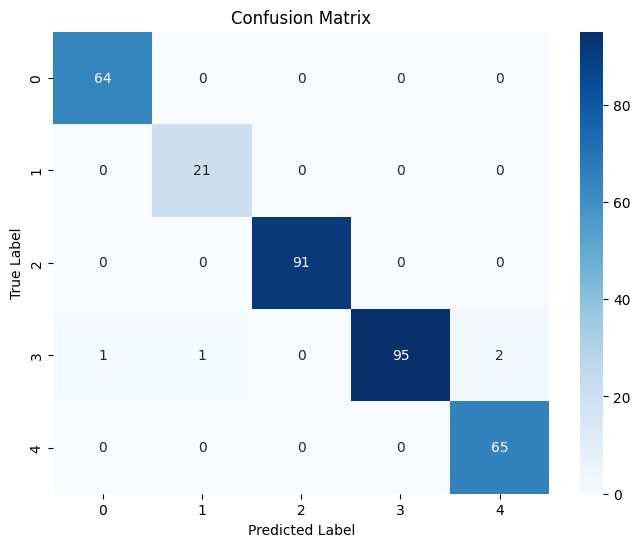

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Predictions
y_pred = loaded_model.predict(x_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true_classes), yticklabels=np.unique(y_true_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # For image loading and preprocessing

def predict_image_class(image_path, model, class_labels):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (x_test_norm.shape[1], x_test_norm.shape[2]))  # Resize to match input size
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the class
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Define your class labels (e.g., 'Cat', 'Dog', etc.)
class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Example usage
image_path = r"A:\Dataset DI\output\hungry - Copy\B327333E-2DE2-4833-A75A-4C576208BED3-1430087456-1.0-f-48-hu.png"

predicted_label = predict_image_class(image_path, model, class_labels)
print(f"The predicted class is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
The predicted class is: hungry
